In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

In [158]:
import pickle

from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

from src.model import get_model, encode_fixing, get_C_GL
from src.net import ObjSurrogate
from src.dataset import EarlyFixingDataset, WellObjDataset

In [159]:
with open('../ef_objs.pkl', 'rb') as f:
    ef_objs = pickle.load(f)

# ef_objs.pop('JUB-48', None)
# ef_objs.pop('JUB-55', None)
# ef_objs.pop('JUB-58', None)
ef_objs.keys()

dict_keys(['RO-133-teste20190730', 'mrl208H', 'RO-167D-teste20190911', 'MLS_167_2021_01_12_potencial', 'abl_correl_tp', '2019.01.22_abl_46_MVM', '2020.11.06_abl_71_P', 'Resultado', '2019.01.22_abl_46_MVM-checkpoint', 'RO-102-potencial_mod_corr_', 'MLS_169_2021_01_15_potencial', 'estudo_gabarito', 'estudo_gabarito_ok', '2021.08.21_abl_16_Potencial', 'filled', '2305_tpr_ajusteIPR', 'abl_44_2021_11_12_P-checkpoint', 'mrl82PROD', 'RO-123-teste20190811_ss', 'RO-112-teste20190716', 'RO-160-teste20190810', 'abl_44_2021_11_12_P', 'RO-158_potencial', 'abl_68_2014_11_', 'MLS_222_2021_02_07_potencial', '2021.11.14_abl_13_P', '2021.09.12_ABL-87_P', '2021.10.23_abl_54_Potencial', 'MLS-225_2019-12-11_potencial', 'RO-100-teste20190827', 'RO-102-IPR-tuning-teste-1-ABL', 'cenario1_gl_1', '2019.02.21_abl_11_P', 'RO-100-potencial', 'cenario1', 'RO-107HPA-teste20190828', 'mls-113_2021-01-09_potencial', 'JUB-6_GL', 'mrl171PROD', 'ajuste_tpr_sem_gl', 'MLS_208_19_01_2021_potencial', 'RO123-potencial', 'MLS_2

In [ ]:
test_wells = ['2022-01-16_JUB-55_SURGENTE_BTP-068b', 'MLS_169_2021_01_15_potencial', 'abl_correl_tp', 'RO-162-teste-20190708', 'RO-158-teste20190903_ss', 'ajuste_tpr_com_ipr1', 'RO-102-IPR-tuning-teste-1-ABL', 'mrl71PROD', 'cenario', 'estudo_gabarito', 'mrl121h', 'MLS_042_2020_11_23_potencial', 'RO-133-teste20190730', 'ab_83_2021_01_09_P_PXO', 'RO-123-teste20190811_ss', 'JUB-9_GL', 'teste', 'MLS-10_2020_12_25_potencial', 'mrl129teste', 'MLS_222_2021_01_01_potencial', 'estudo_gabarito_ok']

In [4]:
X = list()
y = list()
for n in ef_objs.keys():
    for c1, c2, gl1, gl2 in ef_objs[n].keys():
        c_pair = (c1, c2)
        gl_pair = (gl1, gl2)

        c_mbd, gl_mbd = encode_fixing(c_pair, gl_pair, n)
        # c_mbd, gl_mbd = np.array(c_pair), np.array(gl_pair)

        X.append((n, c_mbd, gl_mbd))
        y.append(ef_objs[n][c1, c2, gl1, gl2])

In [5]:
well_name, c_mbd, gl_mbd = X[0]

with open('../data/raw/'+well_name+'.pkl', 'rb') as f:
    well = pickle.load(f)

model = get_model([well,], avoid_infeasible=False)

A = model.getA().toarray()
b = np.array(model.getAttr('rhs'))

A = torch.from_numpy(A).unsqueeze(0)
b = torch.from_numpy(b).unsqueeze(0)
z_c = torch.from_numpy(c_mbd).unsqueeze(0)
z_gl = torch.from_numpy(gl_mbd).unsqueeze(0)

x = torch.hstack([A.flatten(1), b, z_c, z_gl])
x.shape

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-10


torch.Size([1, 1544])

In [11]:
len(X) / 116

25.0

mrl207


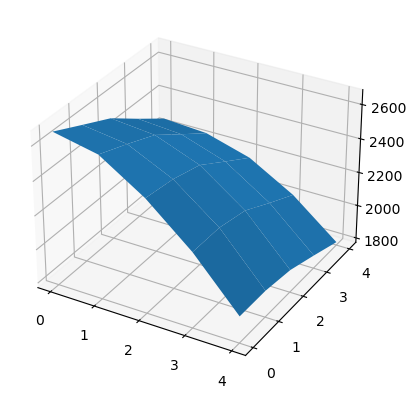

In [156]:
# C, GL = get_C_GL(None)

# well_name = list(ef_objs.keys())[116]
well_name = 'mrl207'

C = np.arange(len(c_mbd))
GL = np.arange(len(gl_mbd))

C, GL = np.meshgrid(C, GL)

Obj = -1 * np.ones(C.shape)
Obj

for (n, c_mbd, gl_mbd), obj in zip(X, y):
    if n == well_name:
        Obj[c_mbd.argmax(), gl_mbd.argmax()] = obj

print(well_name)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(GL, C, Obj)
plt.show()

bad wells:

- abl_68_2014_11_22-checkpoint
- RO-154-TesteBR-SiOP
- RO-111-TesteBR-SiOP
- 2022-01-02_JUB-58_SURGENTE_BTP-068
- 2022-01-17_JUB-48_SURGENTE_BTP-045

hard wells:

- 2021.08.21_abl_16_Potencial
- **mrl51PROD**
- **MLS-200_2021-02-13_potencial**
- **MLS-200_2021-01-04_pot**
- abl_44_2021_11_12_P-checkpoint
- RO-112-teste20190716
- 2021.11.14_abl_13_P
- RO123-potencial
- RO-TPR
- RO-162-teste-20190708
- RO-82-Teste
- **mrl207**
- **MRL-207**
- **mrl69PROD**

In [32]:
ws = list(ef_objs.keys())

array([32, 25, 27, 20, 18, 16, 36, 26, 14,  1, 24, 23, 11, 19,  8, 28, 33,
       21, 13,  2,  3,  0, 17, 12, 30,  9,  6, 10, 29])

In [160]:
ds = WellObjDataset(ef_objs)
(q_liq_fun, bsw, gor, c_mbd, gl_mbd), y = ds[-1]

q_liq_fun_flat = q_liq_fun.flatten()

q_liq_fun_flat = torch.from_numpy(q_liq_fun_flat).unsqueeze(0)
bsw = torch.Tensor([bsw,]).unsqueeze(0)
gor = torch.Tensor([gor,]).unsqueeze(0)
z_c = torch.from_numpy(c_mbd).unsqueeze(0)
z_gl = torch.from_numpy(gl_mbd).unsqueeze(0)

x = torch.hstack([q_liq_fun_flat, bsw, gor, z_c, z_gl])
x.shape

torch.Size([1, 48])

In [161]:
n = 0
ys = list()
for _, y in ds:
    if y < 0:
        n += 1
    else:
        ys.append(y)

n / len(ds)

0.09703703703703703

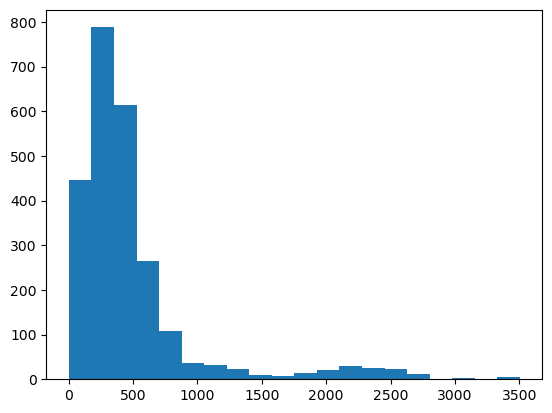

In [162]:
plt.hist(ys, bins=20)
plt.show()

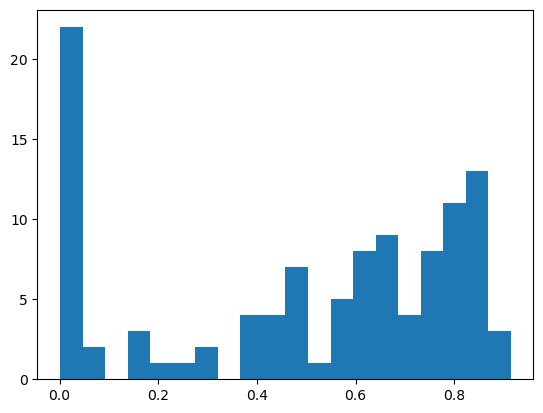

In [164]:
bsws = list()
gors = list()
q_liqs = list()
for well_fp in Path('../data/raw').glob('*.pkl'):
    with open(well_fp, 'rb') as f:
        well = pickle.load(f)
    
    bsws.append(well['bsw'])
    gors.append(well['gor'])
    q_liqs.append(well['curve'])

plt.hist(bsws, bins=20)
plt.show()

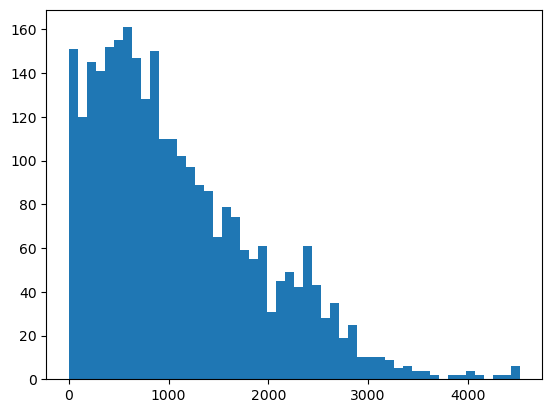

In [165]:
plt.hist(np.hstack([np.array(list(ql.values())) for ql in q_liqs]), bins=50)
plt.show()

# Train

In [49]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

net = ObjSurrogate(layers=[1000, 100, 10, 1]).double().to(device)

opt = torch.optim.Adam(net.parameters(), lr=.01)
loss_fun = torch.nn.MSELoss()

ef_objs_train = ef_objs.copy()
ef_objs_train.pop('JUB-58', None)
ef_objs_train.pop('JUB-55', None)

ds_train = EarlyFixingDataset(ef_objs_train)

ef_objs_test = ef_objs.copy()
ef_objs_test.pop('JUB-58', None)
ef_objs_test.pop('JUB-55', None)

ds_test = EarlyFixingDataset(ef_objs_test)

dl_train = DataLoader(ds_train, 2**4, shuffle=True)
dl_test = DataLoader(ds_test, 2**4)

train_losses = list()
test_losses = list()
for _ in tqdm(list(range(10000))):
    net.train()
    train_loss = 0
    for (A, b, z_c, z_gl), y in dl_train:

        y_hat = net(A.to(device), b.to(device), z_c.to(device), z_gl.to(device))

        loss = loss_fun(y_hat, y.unsqueeze(-1).double().to(device))

        opt.zero_grad()
        loss.backward()
        opt.step()

        train_loss += loss.item() / len(y)
        break
    train_losses.append(train_loss / len(dl_train))

    net.eval()
    test_loss = 0
    for (A, b, z_c, z_gl), y in dl_test:
        with torch.no_grad():
            y_hat = net(A.to(device), b.to(device), z_c.to(device), z_gl.to(device))

            loss = loss_fun(y_hat, y.unsqueeze(-1).double().to(device))

        test_loss += loss.item() / len(y)
    test_losses.append(test_loss / len(dl_test))

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.title('Loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.yscale('log')
plt.show()

Set parameter IntFeasTol to value 1e-09
Set parameter IntFeasTol to value 1e-09


  0%|          | 0/10000 [00:00<?, ?it/s]

TypeError: ObjSurrogate.forward() missing 3 required positional arguments: 'gor', 'z_c', and 'z_gl'

In [85]:
(A, b, z_c, z_gl), y = next(iter(dl_train))

net(A.to(device), b.to(device), z_c.to(device), z_gl.to(device))

tensor([[-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846]], device='cuda:0', dtype=torch.float64,
       grad_fn=<AddmmBackward0>)

In [ ]:
import torch.nn as nn

ae = nn.Sequential(
    # Encoder
    nn.Linear(4458, 1000),
    nn.ReLU(),
    nn.Linear(1000, 1000),
    nn.ReLU(),
    nn.Linear(1000, 100),
    nn.ReLU(),
    # Decoder
    nn.Linear(100, 1000),
    nn.ReLU(),
    nn.Linear(1000, 1000),
    nn.ReLU(),
    nn.Linear(1000, 4458),
).double()

x_hat = ae(x)

x_hat

tensor([[-225.9397,  547.1585,   78.6895,  ..., -120.5317, -549.2405,
          277.7825]], dtype=torch.float64, grad_fn=<AddmmBackward0>)

## Trained model

In [61]:
from src.utils import load_from_wandb
from src.trainer import ObjectiveSurrogateTrainer

net = ObjSurrogate(layers=[50, 20, 10, 1]).double()
net = load_from_wandb(net, '6z9f5sud', 'gef-fs').to(device)

trainer = ObjectiveSurrogateTrainer(net, '../ef_objs.pkl')
trainer.prepare_data()
dl_train, dl_test = trainer.data, trainer.val_data

(C, GL, q_liq_fun, bsw, gor, z_c, z_gl), y = next(iter(dl_train))
C = C.to(device)
GL = GL.to(device)
q_liq_fun = q_liq_fun.to(device)
bsw = bsw.to(device)
gor = gor.to(device)
z_c = z_c.to(device)
z_gl = z_gl.to(device)

y

tensor([-1.0000e+00, -1.0000e+00, -1.0000e+00,  1.0052e+03, -1.0000e+00,
        -1.0000e+00,  1.0530e+03, -1.0000e+00, -1.0000e+00,  9.5818e+02,
        -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
        -1.0000e+00, -1.0000e+00,  1.0226e+03, -1.0000e+00, -1.0000e+00,
         1.0530e+03, -1.0000e+00,  1.0530e+03, -1.0000e+00, -1.0000e+00,
        -1.0000e+00,  9.8902e+02, -1.0000e+00,  9.7007e+02, -1.0000e+00,
         9.9657e+02, -1.0000e+00,  1.0530e+03, -1.0000e+00, -1.0000e+00,
         1.0530e+03, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
        -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,  1.0493e+03,
        -1.0000e+00,  9.0781e+02,  1.0530e+03, -1.0000e+00, -1.0000e+00,
         8.8357e+02, -1.0000e+00, -1.0000e+00, -1.0000e+00,  9.8026e+02,
         1.0530e+03, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         1.0371e+03, -1.0000e+00, -1.0000e+00, -1.0000e+00])

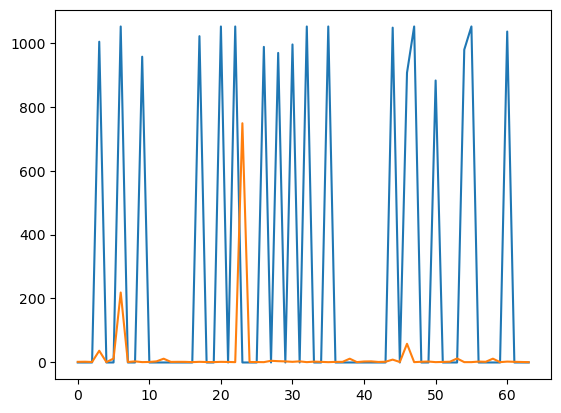

In [72]:
with torch.no_grad():
    y_hat = net(C, GL, q_liq_fun, bsw, gor, z_c, z_gl)

plt.plot(y.cpu())
plt.plot((y.cpu() - y_hat.cpu().squeeze()).abs())
plt.show()